In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import os
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from io import StringIO
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles

import warnings
warnings.filterwarnings('ignore')

In [2]:
class NGLStationMetadata:
    def __init__(self, metadata_url="http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt"):
        """
        Initialize and load station metadata
        """
        self.metadata_url = metadata_url
        self.metadata_df = self._load_metadata()
    
    def _load_metadata(self):
        """
        Load and parse the DataHoldings.txt file with correct column positions
        Header: Sta  Lat(deg)   Long(deg) Hgt(m)  X(m)           Y(m)         Z(m)          Dtbeg      Dtend      Dtmod      NumSol StaOrigName
        """
        try:
            response = requests.get(self.metadata_url)
            response.raise_for_status()
            
            # Define column positions based on the fixed-width format
            colspecs = [
                (0, 4),    # Sta
                (5, 14),   # Lat(deg)
                (15, 24),  # Long(deg)
                (25, 32),  # Hgt(m)
                (33, 46),  # X(m)
                (47, 60),  # Y(m)
                (61, 74),  # Z(m)
                (75, 85),  # Dtbeg
                (86, 96),  # Dtend
                (97, 107), # Dtmod
                (108, 114),# NumSol
                (115, None)# StaOrigName
            ]
            
            # Read the fixed-width formatted file
            df = pd.read_fwf(StringIO(response.text), colspecs=colspecs, skiprows=1,
                           names=['station', 'latitude', 'longitude', 'height', 
                                 'X', 'Y', 'Z', 'start_date', 'end_date', 
                                 'modified_date', 'num_solutions', 'original_name'])
            
            # Convert dates to datetime
            for date_col in ['start_date', 'end_date', 'modified_date']:
                df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='coerce')
            
            # Clean numeric columns
            numeric_cols = ['latitude', 'longitude', 'height', 'X', 'Y', 'Z']
            for col in numeric_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')

            # Convert longitude from 0-360 to -180-180
            df['longitude'] = df['longitude'].apply(lambda x: x - 360 if x > 180 else x)
            
            # Remove rows with NaN in critical columns
            df = df.dropna(subset=['station', 'latitude', 'longitude', 'start_date', 'end_date'])
            
            return df
            
        except requests.RequestException as e:
            print(f"Error fetching metadata: {e}")
            return pd.DataFrame()
    
    def filter_stations(self, area_bounds, start_date, end_date):
        """
        Filter stations based on geographical area and date range
        
        Parameters:
        area_bounds: tuple (min_lat, max_lat, min_lon, max_lon)
        start_date: string 'YYYY-MM-DD'
        end_date: string 'YYYY-MM-DD'
        
        Returns:
        DataFrame with filtered stations
        """
        min_lat, max_lat, min_lon, max_lon = area_bounds
        
        # Convert dates and ensure they're datetime objects
        try:
            start_dt = pd.to_datetime(start_date)
            end_dt = pd.to_datetime(end_date)
        except Exception as e:
            raise ValueError(f"Invalid date format. Dates should be 'YYYY-MM-DD': {e}")

        # Add debug prints to check input values
        print(f"Filtering criteria:")
        print(f"Latitude range: {min_lat} to {max_lat}")
        print(f"Longitude range: {min_lon} to {max_lon}")
        print(f"Date range: {start_dt} to {end_dt}")
        print(f"Initial DataFrame size: {len(self.metadata_df)}")
        
        # Create individual masks and check their effects
        lat_mask = self.metadata_df['latitude'].between(min_lat, max_lat)
        lon_mask = self.metadata_df['longitude'].between(min_lon, max_lon)
        start_mask = self.metadata_df['start_date'] <= end_dt
        end_mask = self.metadata_df['end_date'] >= start_dt
        
        # Print debug information for each mask
        print(f"Stations within latitude range: {lat_mask.sum()}")
        print(f"Stations within longitude range: {lon_mask.sum()}")
        print(f"Stations starting before end date: {start_mask.sum()}")
        print(f"Stations ending after start date: {end_mask.sum()}")
        
        # Combine all masks
        mask = lat_mask & lon_mask & start_mask & end_mask
        
        # Create filtered DataFrame
        filtered_df = self.metadata_df[mask].copy()
        
        # Additional debug information
        print(f"\nFound {len(filtered_df)} stations matching all criteria")
        
        # If no stations found, provide more detailed information
        if len(filtered_df) == 0:
            print("\nDebug information for empty result:")
            print(f"Latitude range in data: {self.metadata_df['latitude'].min()} to {self.metadata_df['latitude'].max()}")
            print(f"Longitude range in data: {self.metadata_df['longitude'].min()} to {self.metadata_df['longitude'].max()}")
            print(f"Date range in data: {self.metadata_df['start_date'].min()} to {self.metadata_df['end_date'].max()}")
        
        return filtered_df

In [3]:
class NGLDataDownloader:
    def __init__(self):
        """
        Initialize the downloader with metadata handler
        """
        self.stations_url = "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/"
        self.metadata = NGLStationMetadata()
    
    def download_tenv3(self, station_id, start_date=None, end_date=None):
        """
        Download and process TENV3 data for a specific station
        """
        try:
            file_url = urljoin(self.stations_url, f"{station_id}.tenv3")
            print('file_url: ', file_url)
            response = requests.get(file_url)
            response.raise_for_status()
            
            content = response.content.decode('utf-8')
            
            # Process the TENV3 file content
            return self._parse_tenv3_content(content, start_date, end_date)
            
        except requests.RequestException as e:
            print(f"Error downloading data for station {station_id}: {e}")
            return None

    def _parse_tenv3_content(self, content, start_date=None, end_date=None):
        """
        Parse TENV3 file content into a pandas DataFrame
        Header format:
        site YYMMMDD yyyy.yyyy __MJD week d reflon *e0(m) *_east(m) ____n0(m) *north(m) u0(m) *___up(m) *ant(m) 
        sig*e(m) sig_n(m) sig_u(m) __corr_en __corr_eu __corr_nu *latitude(deg) *longitude(deg) __height(m)
        """
        # Split content into lines and remove empty lines
        lines = [line.strip() for line in content.split('\n') if line.strip()]
        
        # Find and store the header line
        header_line = None
        data_lines = []
        for line in lines:
            if line.startswith('site '):
                header_line = line
            elif not line.startswith('#'):
                data_lines.append(line)
        
        if not data_lines:
            return None
            
        # Create DataFrame
        df = pd.DataFrame([line.split() for line in data_lines])
        
        if len(df.columns) < 21:  # Check if we have all expected columns
            print(f"Warning: Expected 21 columns, got {len(df.columns)}")
            return None
            
        # Assign column names based on the file format
        df.columns = [
            'site', 'date', 'decimal_year', 'MJD', 'GPS_Week', 'day_of_week',
            'reflon', 'e0', 'east', 'n0', 'north', 'u0', 'up', 'ant_height',
            'sigma_east', 'sigma_north', 'sigma_up',
            'correlation_en', 'correlation_eu', 'correlation_nu',
            'latitude', 'longitude', 'height'
        ][:len(df.columns)]  # Slice in case there are fewer columns than expected
        
        # Convert numeric columns
        numeric_columns = [
            'decimal_year', 'MJD', 'GPS_Week', 'day_of_week',
            'e0', 'east', 'n0', 'north', 'u0', 'up', 'ant_height',
            'sigma_east', 'sigma_north', 'sigma_up',
            'correlation_en', 'correlation_eu', 'correlation_nu',
            'latitude', 'longitude', 'height'
        ]
        
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Convert date string 'YYMMMDD' (e.g., '11OCT26' for 2011/10/26) to datetime
        df['timestamp'] = pd.to_datetime(df['date'], format='%y%b%d')   
        
        # Filter by date range if provided
        if start_date:
            start_dt = pd.to_datetime(start_date)
            df = df[df['timestamp'] >= start_dt]
        if end_date:
            end_dt = pd.to_datetime(end_date)
            df = df[df['timestamp'] <= end_dt]
        
        # Drop rows with NaN values
        df = df.dropna(subset=['east', 'north', 'up'])
        
        return df

    @staticmethod
    def _gps_to_datetime(gps_week, seconds_of_week):
        """
        Convert GPS week and seconds to datetime
        """
        gps_epoch = datetime(1980, 1, 6)
        week_seconds = gps_week * 7 * 24 * 3600
        total_seconds = week_seconds + seconds_of_week
        return gps_epoch + pd.Timedelta(seconds=total_seconds)

In [6]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two points in kilometers
    """
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [8]:
downloader = NGLDataDownloader()

area_bounds = (31.75, 33.75, -98.25, -95.75)
start_date = '2020-01-01'
end_date = '2024-01-31'

# Get filtered stations
filtered_stations = downloader.metadata.filter_stations(area_bounds, start_date, end_date)
print(f"Found {len(filtered_stations)} stations in specified area and time period")

# Download data for each station
all_data = []
for _, station in filtered_stations.iterrows():
    print(f"Downloading data for station {station['station']}...")
    df = downloader.download_tenv3(station['station'], start_date, end_date)
    if df is not None:
        df['station'] = station['station']
        all_data.append(df)

if not all_data:
    raise ValueError("No data downloaded for any station")

# Combine all data
combined_data = pd.concat(all_data, ignore_index=True)

Filtering criteria:
Latitude range: 31.75 to 33.75
Longitude range: -98.25 to -95.75
Date range: 2020-01-01 00:00:00 to 2024-01-31 00:00:00
Initial DataFrame size: 12209
Stations within latitude range: 484
Stations within longitude range: 346
Stations starting before end date: 11997
Stations ending after start date: 9438

Found 31 stations matching all criteria
Found 31 stations in specified area and time period
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/RICE.tenv3
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/TX90.tenv3
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/TXAH.tenv3
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/TXAS.tenv3
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/TXBN.tenv3
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/TXDA.tenv3
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/TXDC.tenv3
file_url:  http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/TXDE.tenv3
file_url

In [9]:
combined_data

,site,date,decimal_year,MJD,GPS_Week,day_of_week,reflon,e0,east,n0,...,sigma_north,sigma_up,correlation_en,correlation_eu,correlation_nu,latitude,longitude,height,timestamp,station
0,RICE,20JAN01,2020.0000,58849,2086,3,-96.5,18,0.458214,3568864,...,0.000764,0.002729,-0.007930,0.003522,-0.077619,32.243598,-96.499804,119.79844,2020-01-01,RICE
1,RICE,20JAN02,2020.0027,58850,2086,4,-96.5,18,0.457129,3568864,...,0.000769,0.002786,0.003783,0.016372,-0.078946,32.243598,-96.499804,119.80801,2020-01-02,RICE
2,RICE,20JAN03,2020.0055,58851,2086,5,-96.5,18,0.456268,3568864,...,0.000783,0.002754,0.004776,0.028106,-0.111879,32.243598,-96.499804,119.79550,2020-01-03,RICE
3,RICE,20JAN04,2020.0082,58852,2086,6,-96.5,18,0.455559,3568864,...,0.000798,0.002784,-0.014489,0.043505,-0.087229,32.243598,-96.499804,119.79013,2020-01-04,RICE
4,RICE,20JAN05,2020.0110,58853,2087,0,-96.5,18,0.456232,3568864,...,0.000773,0.002767,0.008273,0.011443,-0.075622,32.243598,-96.499804,119.79261,2020-01-05,RICE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38974,ZFW1,24JAN27,2024.0712,60336,2298,6,-97.1,3139,0.157255,3633966,...,0.000758,0.002733,-0.013339,0.006128,-0.140645,32.830649,-97.066473,155.17322,2024-01-27,ZFW1
38975,ZFW1,24JAN28,2024.0739,60337,2299,0,-97.1,3139,0.155497,3633966,...,0.000744,0.002629,-0.026478,0.036965,-0.112507,32.830649,-97.066473,155.16719,2024-01-28,ZFW1
38976,ZFW1,24JAN29,2024.0767,60338,2299,1,-97.1,3139,0.155813,3633966,...,0.000742,0.002653,-0.032785,0.030406,-0.140707,32.830649,-97.066473,155.16622,2024-01-29,ZFW1
38977,ZFW1,24JAN30,2024.0794,60339,2299,2,-97.1,3139,0.156583,3633966,...,0.000730,0.002597,-0.028714,0.035702,-0.125533,32.830649,-97.066473,155.16745,2024-01-30,ZFW1


In [10]:
# Get unique stations with their coordinates
unique_stations = combined_data.groupby('site').agg({
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

In [11]:
# Create geometry column for GeoPandas
geometry = [Point(xy) for xy in zip(unique_stations['longitude'], unique_stations['latitude'])]

# Create GeoDataFrame with specified CRS
gdf = gpd.GeoDataFrame(
    unique_stations, 
    geometry=geometry,
    crs="EPSG:4326"  # Explicitly specify WGS84 coordinate system
)

# Plot the stations
gdf.explore(
    marker_kwds={'radius': 6},  # Adjust marker size
    tooltip=['site'],  # Show station name on hover
    popup=True,  # Enable popup on click
    tiles='OpenStreetMap',  # Use OpenStreetMap as background
    style_kwds={'color': 'red'}  # Set marker color
)

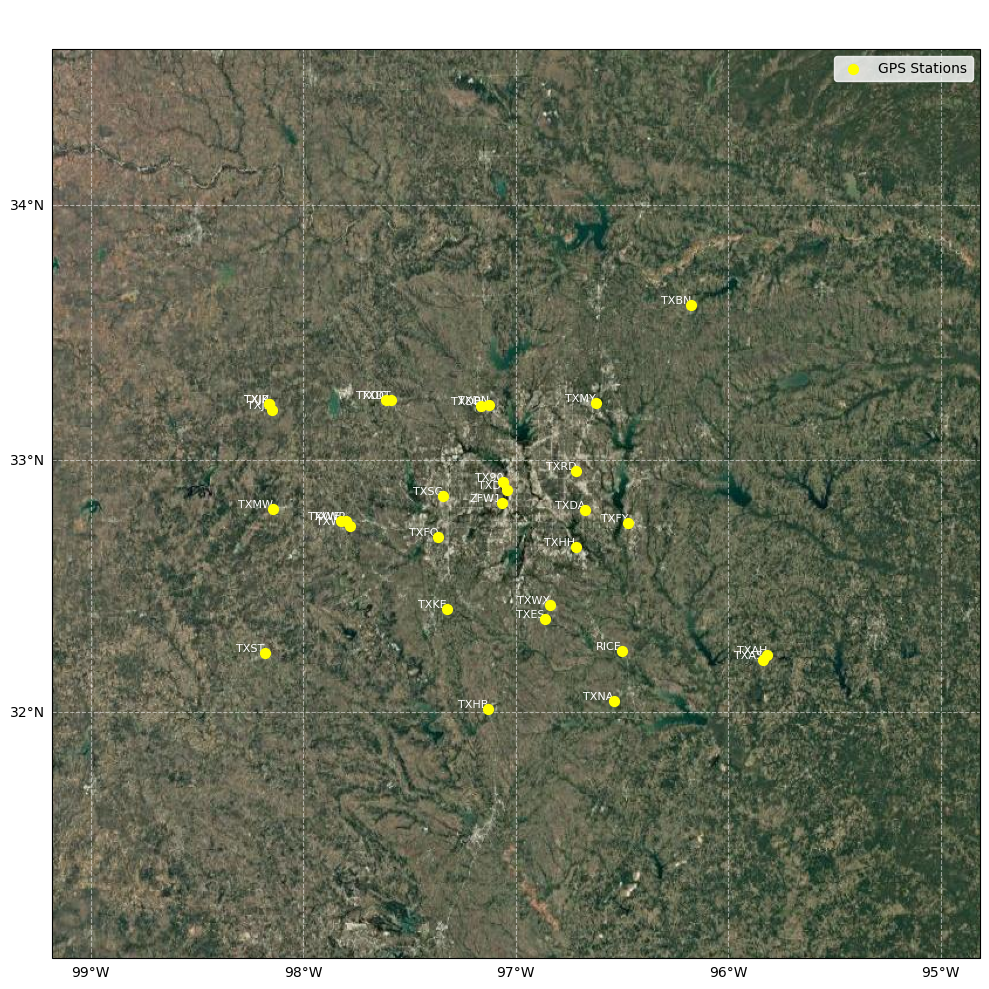

In [12]:
# Create a Google Satellite instance
google_tiles = GoogleTiles(style='satellite')  # can also use 'street' or 'terrain'

# Create figure and axes with projection
fig, ax = plt.subplots(figsize=(15, 10), 
                       subplot_kw={'projection': google_tiles.crs})

# Add the Google satellite imagery
ax.add_image(google_tiles, 8)  # Zoom level 8, adjust as needed

# Add coastlines and borders for reference (optional)
ax.coastlines(resolution='10m', color='white', linewidth=0.5, alpha=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.5, edgecolor='white')

# Calculate the bounds of your data for setting map extent
buffer = 1  # degrees
lon_min, lon_max = gdf.geometry.x.min() - buffer, gdf.geometry.x.max() + buffer
lat_min, lat_max = gdf.geometry.y.min() - buffer, gdf.geometry.y.max() + buffer

# Set map extent [lon_min, lon_max, lat_min, lat_max]
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot GPS stations
ax.scatter(gdf.geometry.x, gdf.geometry.y, 
          transform=ccrs.PlateCarree(),
          color='yellow',  # Changed to yellow for better visibility on satellite imagery
          s=50,  # marker size
          label='GPS Stations',
          zorder=5)

for idx, row in gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row['site'],
            transform=ccrs.PlateCarree(),
            color='white',
            fontsize=8,
            horizontalalignment='right',
            verticalalignment='bottom')

# Add gridlines with white labels for better visibility
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, color='white')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'color': 'black'}
gl.ylabel_style = {'color': 'black'}
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,1.0))
gl.ylocator = mticker.FixedLocator(np.arange(-90,91,1.0))

# Add title and legend
plt.title('GPS Station Locations', color='white', pad=20)
plt.legend(facecolor='white', edgecolor='white')

plt.tight_layout()

In [13]:
site_mask = combined_data['site'] == 'TXRD'
start_dt = pd.to_datetime('2020-01-01')
end_dt = pd.to_datetime('2023-12-31')
start_mask = combined_data['timestamp'] >= start_dt
end_mask = combined_data['timestamp'] <= end_dt

mask = site_mask & start_mask & end_mask

filtered_data = combined_data[mask].copy().reset_index(drop=True)

In [14]:
filtered_data

,site,date,decimal_year,MJD,GPS_Week,day_of_week,reflon,e0,east,n0,...,sigma_north,sigma_up,correlation_en,correlation_eu,correlation_nu,latitude,longitude,height,timestamp,station
0,TXRD,20JAN01,2020.0000,58849,2086,3,-96.7,-1394,-0.128557,3647887,...,0.000786,0.003014,-0.059453,0.099565,-0.254084,32.956175,-96.714911,179.46174,2020-01-01,TXRD
1,TXRD,20JAN02,2020.0027,58850,2086,4,-96.7,-1394,-0.130436,3647887,...,0.000775,0.002874,-0.031304,0.069585,-0.214526,32.956175,-96.714911,179.46967,2020-01-02,TXRD
2,TXRD,20JAN03,2020.0055,58851,2086,5,-96.7,-1394,-0.131250,3647887,...,0.000815,0.003085,-0.040880,0.056608,-0.247676,32.956175,-96.714911,179.45570,2020-01-03,TXRD
3,TXRD,20JAN04,2020.0082,58852,2086,6,-96.7,-1394,-0.130765,3647887,...,0.000807,0.003026,-0.041550,0.074868,-0.253197,32.956175,-96.714911,179.45476,2020-01-04,TXRD
4,TXRD,20JAN05,2020.0110,58853,2087,0,-96.7,-1394,-0.130738,3647887,...,0.000801,0.003136,-0.043597,0.079379,-0.277315,32.956175,-96.714911,179.46077,2020-01-05,TXRD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,TXRD,23JUL09,2023.5181,60134,2270,0,-96.7,-1394,-0.176473,3647887,...,0.000796,0.003024,-0.095110,0.071952,-0.179884,32.956175,-96.714911,179.46997,2023-07-09,TXRD
1274,TXRD,23JUL10,2023.5209,60135,2270,1,-96.7,-1394,-0.175558,3647887,...,0.000918,0.003363,-0.078114,-0.026698,-0.099648,32.956175,-96.714911,179.47586,2023-07-10,TXRD
1275,TXRD,23JUL11,2023.5236,60136,2270,2,-96.7,-1394,-0.176417,3647887,...,0.000875,0.003489,-0.074900,0.112335,-0.208802,32.956175,-96.714911,179.47348,2023-07-11,TXRD
1276,TXRD,23JUL12,2023.5264,60137,2270,3,-96.7,-1394,-0.179063,3647887,...,0.000916,0.003434,-0.038816,0.060448,-0.190582,32.956175,-96.714911,179.46124,2023-07-12,TXRD


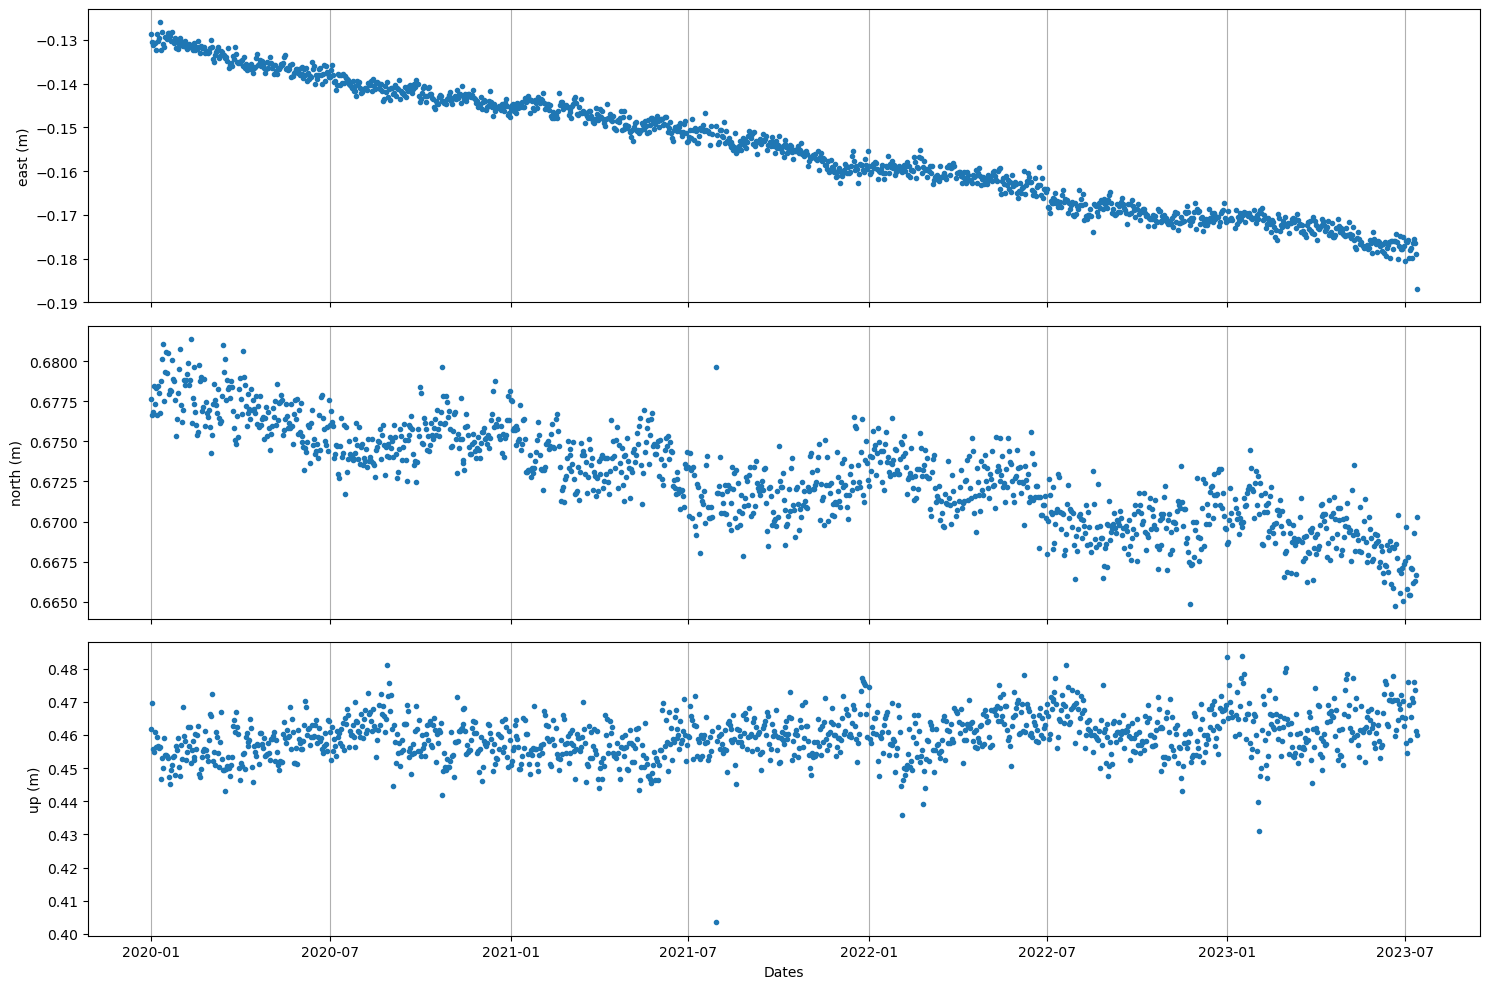

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

ax[0].plot(filtered_data.timestamp, filtered_data.east, '.')
ax[0].set_ylabel("east (m)")
ax[0].grid(axis='x')

ax[1].plot(filtered_data.timestamp, filtered_data.north, '.')
ax[1].set_ylabel("north (m)")
ax[1].grid(axis='x')

ax[2].plot(filtered_data.timestamp, filtered_data.up, '.')
ax[2].set_ylabel("up (m)")
ax[2].grid(axis='x')

ax[2].set_xlabel("Dates")

plt.tight_layout()
plt.show()